In [4]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
%matplotlib inline

Анализ дейтинг приложения.
Помимо базовых функций, в приложении также имеется премиум-подписка, которая дает доступ к ряду важных дополнительных возможностей. Был проведен A/B тест, в рамках которого для новых пользователей из нескольких стран была изменена стоимость премиум-подписки при покупке через две новые платежные системы. При этом стоимость пробного периода оставалась прежней. Проверем: Был ли эксперимент успешен в целом. Проанализируем, имеет ли нововведение смысл среди каких-либо конкретных групп пользователей.

*Деньги за подписку списываются ежемесячно до тех пор, пока пользователь её не отменит.


In [5]:
###Сформируем датафреймы и распарсим даты 

users_test = pd.read_csv("users_test.csv", sep = ';') 
#информация о пользователях в тестовой группе. 

users_control_1 = pd.read_csv("users_control_1.csv", sep = ';') 
#информация о пользователях в первой контрольной группе. 

users_control_2 = pd.read_csv("users_control_2.csv", sep = ';') 
#информация о пользователях во второй контрольной группе . 

transactions_test = pd.read_csv("transactions_test.csv", sep = ';', parse_dates=['joined_at', 'paid_at']) 
#информация о платежах пользователей в тестовой группе.

transactions_control_1 = pd.read_csv("transactions_control_1.csv", sep = ';', parse_dates=['joined_at', 'paid_at']) 
#информация о платежах пользователей в первой контрольной группе. 

transactions_control_2 = pd.read_csv("transactions_control_2.csv", sep = ';', parse_dates=['joined_at', 'paid_at']) 
#информация о платежах пользователей во второй контрольной группе 


#В начале загрузим данные

Всего есть три группы: тестовая (test), контрольная 1 (control_1) и контрольная 2 (control_2).
#Данные
**users_*.csv** – информация о пользователях:

* uid – идентификатор пользователя
* age – возраст
* attraction_coeff – коэффициент привлекательности (от 0 до 1000) 
* coins – число монеток (внутренняя валюта) 
* country – страна
* visit_days – в какие дни после регистрации пользователь посещал приложение (напр. в 1, затем в 7) 
* gender – пол 
* age_filter_start  – фильтр поиска, мин. значение  
* age_filter_end  – фильтр поиска, макс. значение 
* views_count – число полученных оценок  
* was_premium – был ли когда-либо премиум (либо пробный период премиум-статуса, либо купленный за деньги) 
* is_premium –  является ли премиум 
* total_revenue – нормированная выручка 

**transactions_*.csv** – информация о платежах пользователей:

* uid – идентификатор пользователя
* country – страна
* joined_at – дата и время регистрации
* paid_at – дата и время покупки
* revenue – нормированная выручка
* payment_id – идентификатор платежа
* from_page – откуда пользователь перешел на страницу оплаты
* product_type – тип продукта (trial_premium – пробная премиум-подписка, premium_no_trial – премиум-подписка без пробной, coins – подписка за внутреннюю валюту, other_type – другое)

In [6]:
users_control_2.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892035504,37,137,NaN,Israel,"1,2,3,4,5,6,7,8,9,11,13",1,30,40,51,NaN,NaN,0
1,891782112,57,0,NaN,Italy,1,1,54,60,0,NaN,NaN,0
2,891110337,30,769,NaN,France,"1,2,3,4,5",1,27,33,13,NaN,NaN,0
3,891796320,48,750,NaN,France,"1,4,6,8,10,11,12,14,15,16,18",1,45,51,12,NaN,NaN,0
4,891880212,54,638,NaN,United States of America,1,1,35,53,94,NaN,NaN,0


#  Изучение и предподготовка данных

In [7]:
users_test.isna().sum()

uid                    0
age                    0
attraction_coeff       0
coins               4259
country                0
visit_days          1330
gender                 0
age_filter_start       0
age_filter_end         0
views_count            0
was_premium         3900
is_premium          4151
total_revenue          0
dtype: int64

In [8]:
users_test.nunique()

uid                 4308
age                   57
attraction_coeff     600
coins                 28
country               51
visit_days           891
gender                 2
age_filter_start      51
age_filter_end        78
views_count          331
was_premium            1
is_premium             1
total_revenue        105
dtype: int64

In [9]:
transactions_test.nunique()

uid             146
country          17
joined_at       146
paid_at         258
revenue         125
payment_id        6
from_page        22
product_type      4
dtype: int64

In [10]:
 transactions_control_1.isna().sum()

uid             630
country         630
joined_at       630
paid_at         630
revenue         630
payment_id      630
from_page       630
product_type    630
dtype: int64

In [11]:
 #удалим пользователей с нулевыми айди
transactions_control_1 = transactions_control_1.dropna(subset=['uid'])

In [12]:
 # Убираем пустые значения
transactions_control_1.dropna(inplace=True)


In [13]:
#объединим в один датасет все таблицы с пользователями и с оплатами
users_test['group'] = 'test'
users_control_1['group'] = 'control_1'
users_control_2['group'] = 'control_2'
users = users_test.append(users_control_1) \
                  .append(users_control_2) \
                  .fillna(0)

transactions_test['group'] = 'test'
transactions_control_1['group'] = 'control_1'
transactions_control_2['group'] = 'control_2'
transactions = transactions_test.append(transactions_control_1) \
                                .append(transactions_control_2)

users_transactions = pd.merge(users, transactions, how='left', on=['uid', 'group'])

In [14]:
#Создадим возрастные категории  
users_transactions['age_category'] = pd.cut(users_transactions.age, [0, 18, 24, 34, 44, 54, 105], right=False, labels=['0-18', '18-24', '25-35', '35-44', '45-54', '55+'])
users_test['age_category'] = pd.cut(users_test.age, [0, 18, 24, 34, 44, 54, 105], right=False, labels=['0-18', '18-24', '25-35', '35-44', '45-54', '55+'])
users_control_1['age_category'] = pd.cut(users_control_1.age, [0, 18, 24, 34, 44, 54, 105], right=False, labels=['0-18', '18-24', '25-35', '35-44', '45-54', '55+'])
users_control_2['age_category'] = pd.cut(users_control_2.age, [0, 18, 24, 34, 44, 54, 105], right=False, labels=['0-18', '18-24', '25-35', '35-44', '45-54', '55+'])

## АА тесты для проверки качества сплитования

У нас А/А/В тест, т.к 2 контроля и 1 тест. Давайте проверим качество сплитования. Для проверки используем следующие метрики:
1. ARPPU (средняя выручка с платящего пользователя)
2. CR (конверсия в оплату)



  0%|          | 0/10000 [00:00<?, ?it/s]

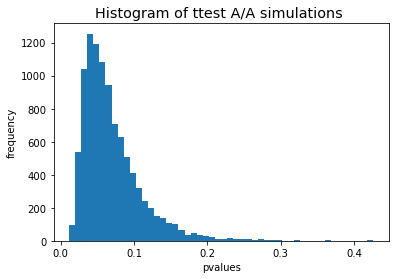

0.3749

In [15]:
simulations = 10000
n_s = 328
res = []

# Запуск симуляций A/A теста:
for i in tqdm(range(simulations)):
    s1 = transactions_control_1['revenue'].sample(n_s, replace = False).values
    s2 = transactions_control_2['revenue'].sample(n_s, replace = False).values
    res.append(ss.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue
    
plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

По первому А/А-тесту видим, что p-value превышает 0.05. Распределение совем не однородное и смещено влево. 

Поскольку данных относительно мало, то возможны выбросы. Они, вероятно, и портят статистические показатели. Давайте построим боксплоты, чтобы посмотреть присутствуют ли выбросы в данных


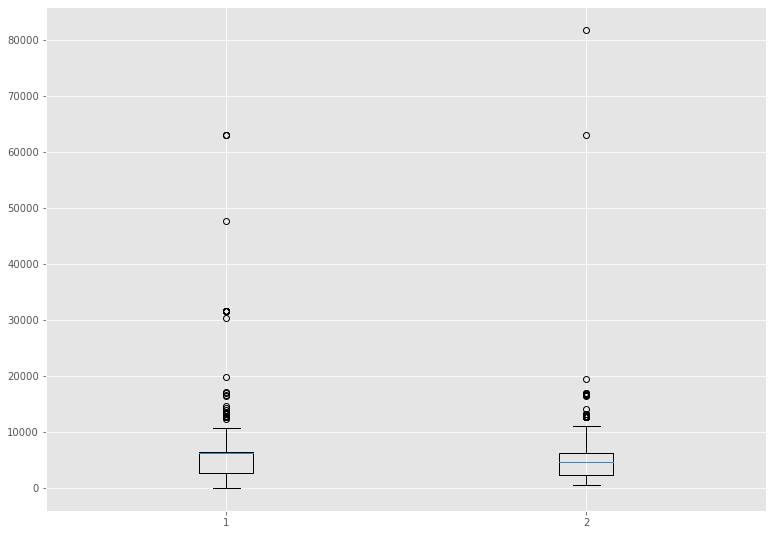

In [16]:
data = [transactions_control_1['revenue'], transactions_control_2['revenue']]

fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(data)
 
# show plot
plt.show()

Выбросы есть. Давайте избавимся от них и проведем А\А-тест еще раз

In [17]:
ejection_1 = transactions_control_1['revenue'].describe()[-2] + (1.5 * (transactions_control_1['revenue'].describe()[-2] - transactions_control_1['revenue'].describe()[-4])) #значения выше являются выбросами
ejection_2 = transactions_control_2['revenue'].describe()[-2] + (1.5 * (transactions_control_2['revenue'].describe()[-2] - transactions_control_2['revenue'].describe()[-4]))

transactions_control_1 = transactions_control_1.query('revenue < @ejection_1')
transactions_control_2 = transactions_control_2.query('revenue < @ejection_2')

In [18]:
transactions_control_2['revenue'].describe()[-2] + (1.5 * (transactions_control_2['revenue'].describe()[-2] - transactions_control_2['revenue'].describe()[-4]))

12707.5

  0%|          | 0/10000 [00:00<?, ?it/s]

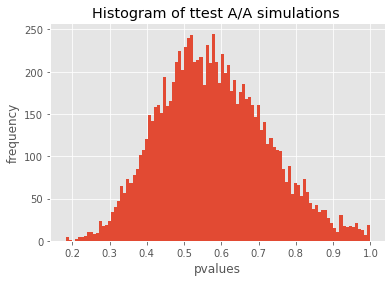

0.0

In [19]:
simulations = 10000
n_s = transactions_control_2.shape[0]
res = []

# Запуск симуляций A/A теста:
for i in tqdm(range(simulations)):
    s1 = transactions_control_1['revenue'].sample(n_s, replace = False).values
    s2 = transactions_control_2['revenue'].sample(n_s, replace = False).values
    res.append(ss.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue
    
plt.hist(res, bins = 100)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

p-value < 0,05, значит между контрольными группами нет значимых различий. Чтобы убедиться в этом построим боксплоты:

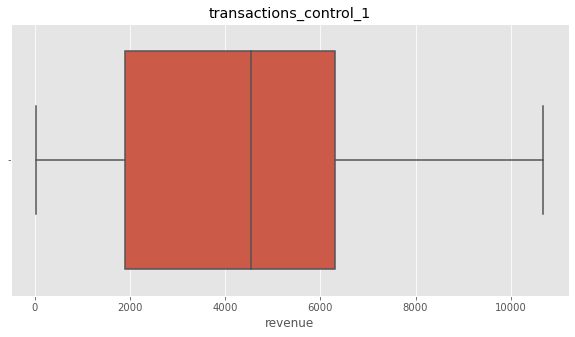

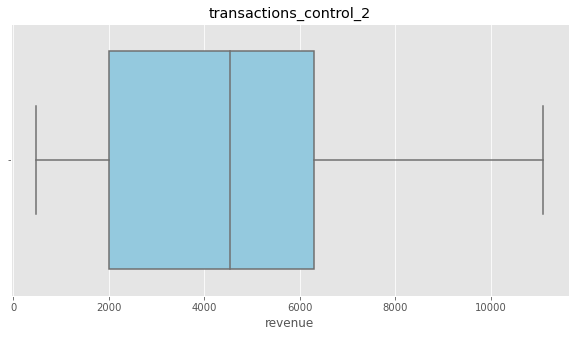

In [20]:
#боксплот по transactions_control_1:
plt.figure(figsize=(10,5))
plt.title("transactions_control_1")
sns.boxplot(x=transactions_control_1['revenue'])
plt.show()

#transactions_control_2:
plt.figure(figsize=(10,5))
plt.title("transactions_control_2")
sns.boxplot(x=transactions_control_2['revenue'], color = 'skyblue')
plt.show()

Судя по боксплотам, различия между контрольными группами явно отстутствуют. Значит, контрольные группы для А/B-теста были сплитованы корректно.

Предположим, что средний чек в тестовой группе при изменении стоимости премиум-подписки статистически значимо изменился по сравнению со ср. чеком в контрольной группе. 

Для подтверждения данной гипотезы необходимо отвергнуть нулевую гипотезу Н0 о том, что значение среднего чека в тестовой и контрольных группах статистически значимо НЕ отличается. Для проверки будем использовать бутстрап. 

Построим боксплот тестовой группы transactions_test, чтобы примерно представлять ее основные статистические характеристики и выявить случайные выбросы.

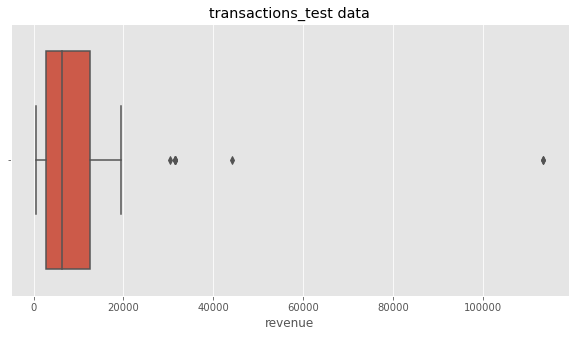

In [21]:
# Построим боксплот для transactions_test, чтобы выявить выбросы:

plt.figure(figsize=(10,5))
plt.title("transactions_test data")
sns.boxplot(x=transactions_test['revenue'])
plt.show()

In [22]:
#Видим явные 4 выброса. Давайте от них избавимся 
transactions_test = transactions_test.query('revenue <= 20000')

In [23]:

print(f"Средний чек в тестовой группе {round(transactions_test['revenue'].mean())}")

print(f"Средний чек в 1-ой контр. группее {round(transactions_control_1['revenue'].mean())}")

print(f"Средний чек во 2-ой контр. группее равен {round(transactions_control_2['revenue'].mean())}")


Средний чек в тестовой группе 7051
Средний чек в 1-ой контр. группее 4539
Средний чек во 2-ой контр. группее равен 4414


# A/B тест, Бутстрап: сравним тестовую выборку  с 1 контрольной выборкой

In [24]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 10000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика(среднее, т.к ищем ср.чек)
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2))
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = ss.norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = ss.norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

  0%|          | 0/10000 [00:00<?, ?it/s]

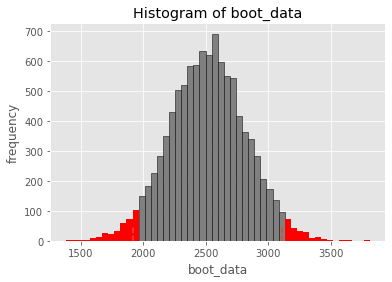

In [25]:
booted_data = get_bootstrap(transactions_test['revenue'] , transactions_control_1['revenue'] , boot_it = 10000)

In [26]:
booted_data["p_value"]

1.5648888127710322e-16

In [27]:
booted_data["quants"]

,0
0.025,1917.431153
0.975,3108.628037


# А/В тест, Бутстрап: сравним тестовую выборку  с 2 контрольной выборкой

  0%|          | 0/10000 [00:00<?, ?it/s]

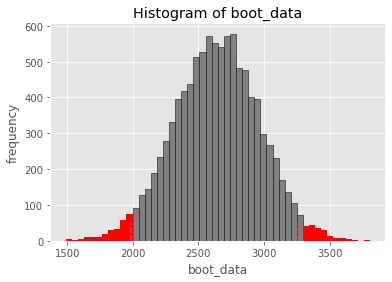

In [28]:
booted_data_1 = get_bootstrap(transactions_test['revenue'] , transactions_control_2['revenue'] , boot_it = 10000)

In [29]:
booted_data_1["p_value"]

4.2509464405022786e-16

In [30]:
booted_data_1["quants"]

,0
0.025,1989.247938
0.975,3259.266409


In [31]:
transactions_test

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
0,891345942,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909,147,trial_vip_popup,trial_premium,test
1,892054251,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923,147,trial_vip_popup,trial_premium,test
2,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type,test
3,892236423,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783,67,menu,other_type,test
4,892168170,United States of America,2017-10-19 17:10:00,2017-10-27 19:10:00,9087,147,trial_vip_popup,trial_premium,test
...,...,...,...,...,...,...,...,...,...
268,891419625,Israel,2017-04-11 05:58:00,2017-11-11 08:33:00,14352,147,trial_vip_popup,trial_premium,test
269,891447105,United Kingdom (Great Britain),2017-03-11 17:05:00,2017-11-11 04:23:00,7319,147,fans,premium_no_trial,test
270,891497073,United States of America,2017-02-11 15:33:00,2017-05-11 04:06:00,2730,67,empty_likes,other_type,test
271,891406224,Israel,2017-04-11 12:56:00,2017-04-11 13:35:00,2743,67,empty_likes,other_type,test


In [32]:
ss.mannwhitneyu(transactions_test.revenue, transactions_control_2.revenue)

MannwhitneyuResult(statistic=48916.0, pvalue=1.4665345681429054e-08)

In [33]:
 np.mean(booted_data_1['boot_data'])

2636.103935051547

Думаю, наиболее вероятную разницу между ср. чеком тестовой группы и ср. чеком 1 контрольной группы олицетворяет медиана(кот-ая равна моде). Найдём её

In [34]:
print(f"Разница среднего чека тестовой группы от 1 контрольной группы 1 = {round(np.median(booted_data['boot_data']), 0)}")

print(f"Разница среднего чека тестовой группы от 2 контрольной группы 2 = {round(np.median(booted_data_1['boot_data']),0)}")

Разница среднего чека тестовой группы от 1 контрольной группы 1 = 2515.0
Разница среднего чека тестовой группы от 2 контрольной группы 2 = 2641.0


#Вывод
Отвергаем нулевую гипотезу Н0 с 95% уровнем значимости, таким образом **разница** между средним чеком в тестовой группе и средним чеке в двух контрольных грппах действительно **есть**. Причем эта разница наиболее вероятно лежит в диапозоне 2500-2650 единиц

Также, наш вывод, подтверждают значения p-value, которые действительно очень низки. 
Таким образом, при изменении стоимости премиум-подписки средний чек генеральной совокупности возрастет на 2400-2600 на 95% уровне значимости. 

# Быть может, нововведение имеет смысл среди каких-то конкретных групп пользователей?

Логичным будет предположить, что группы пользователей, среди которых есть смысл делать нововведение, могут быть обнаружены в процессе работы, например, со следующими категориями:

*   age (возраст) - думаю, пользователи возраста 20-30 лет, более мотивированы на знакомства, чем пользователи 50-60-летнего возраста

*   product_type (тип продукта) - средний чек в зависимости от типа продукта может меняться

*   country (страна) - страны различаются по уровню жизни, экономического развитию, традициям, думаю, стоит и тут проверить

*   attraction_coeff (привлекательность) - коэффициент привлекательности это основа экономики дейтинговых приложений, характеризующая в том числе и поведение пользователя.


#  Посмотрим на данные в разрезе стран:

In [35]:
#Сгруппируем по стране, посчитаем выручку и кол-во платежей, уберём страны, 
#чье кол-во транзакций меньше 10 дабы как-то прикинуть настоящий средний чек 
country_group_test = transactions_test.groupby('country', as_index = False) \
                                      .agg({'revenue':'sum', 'payment_id':'count'}) \
                                      .rename(columns={'payment_id':'transactions'}) \
                                      .query('transactions > 10')                                           

# Вычислим средний чек у каждой страны:
country_group_test['AOV_test'] = (country_group_test['revenue']/country_group_test['transactions']).round(0)

In [36]:
country_group_test

,country,revenue,transactions,AOV_test
3,Canada,63466,11,5770.0
4,Chile,69940,12,5828.0
5,France,253617,33,7685.0
7,Israel,94809,15,6321.0
8,Italy,113425,20,5671.0
11,Spain,171951,24,7165.0
14,United Arab Emirates,100308,11,9119.0
15,United Kingdom (Great Britain),77376,12,6448.0
16,United States of America,658788,92,7161.0


In [37]:
# Выполним то же для контрольной выборки 1
country_group_1 = transactions_control_1.groupby('country', as_index = False) \
                                        .agg({'revenue':'sum', 'payment_id':'count'}) \
                                        .rename(columns={'payment_id':'transactions'}) \
                                        .query('transactions > 10') 

country_group_1['AOV_control_1'] = (country_group_1['revenue']/country_group_1['transactions']).round(0)       

In [38]:
# И для контрольной выборки 2
country_group_2 = transactions_control_2.groupby('country', as_index = False) \
                                        .agg({'revenue':'sum', 'payment_id':'count'}) \
                                        .rename(columns={'payment_id':'transactions'}) \
                                        .query('transactions > 5') 

country_group_2['AOV_control_2'] = (country_group_2['revenue']/country_group_2['transactions']).round(0) 

In [39]:
#Удалим лишние столбцы у всех датафреймов
country_group_test = country_group_test.drop(columns=['revenue', 'transactions'])
country_group_1 = country_group_1.drop(columns=['revenue', 'transactions'])
country_group_2 = country_group_2.drop(columns=['revenue', 'transactions'])

# Объединим все таблицы
country_group = country_group_test.merge(country_group_1, on = 'country', how = 'left') \
                  .merge(country_group_2, on = 'country', how = 'left')
country_group

,country,AOV_test,AOV_control_1,AOV_control_2
0,Canada,5770.0,6105.0,NaN
1,Chile,5828.0,4870.0,5297.0
2,France,7685.0,3424.0,4056.0
3,Israel,6321.0,4473.0,3446.0
4,Italy,5671.0,3503.0,2876.0
5,Spain,7165.0,5157.0,4039.0
6,United Arab Emirates,9119.0,NaN,NaN
7,United Kingdom (Great Britain),6448.0,5928.0,4824.0
8,United States of America,7161.0,4942.0,4613.0


**Инсайнт**: Таким образом, по полученному датафрейму видим, что средний чек увеличился во Франции, Израиле, Италии, Испании, США и ЮК. Очень хотелось бы провести А/В тест на большем количестве данных, т.к транзакций по странам относительно немного, и не стоит полагаться на реальный прирост среднего чека в этих странах при распространении на генеральную совокупность

# Посмотрим на данные в разрезе возраста:

In [40]:
users_control_1

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group,age_category
0,892319115,25,435,NaN,United States of America,"1,2,3,4,5,6",0,22,32,982,NaN,NaN,0,control_1,25-35
1,891248523,29,500,NaN,United States of America,"1,2",1,26,32,12,NaN,NaN,0,control_1,25-35
2,891670932,33,800,NaN,France,"1,2,3,5,6,8,9,11,13,16",1,30,36,5,NaN,NaN,0,control_1,25-35
3,891060786,26,0,NaN,Argentina,"1,2,3,4,5",1,23,29,0,NaN,NaN,0,control_1,25-35
4,892006554,35,294,NaN,United States of America,"1,2,3,5,6,7,8,9,10,12,15,16,17,19",1,30,40,17,NaN,NaN,0,control_1,35-44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4335,892022304,26,227,NaN,United States of America,NaN,0,23,29,427,NaN,NaN,0,control_1,25-35
4336,891905022,38,200,NaN,Argentina,"1,2,3,4,5,6,7,8,9,10,11,13,14,15,16,21",1,20,50,5,NaN,NaN,0,control_1,35-44
4337,891304722,49,411,NaN,United States of America,1,1,46,52,17,NaN,NaN,0,control_1,45-54
4338,891302328,27,0,NaN,United States of America,"1,3,5",1,24,30,0,NaN,NaN,0,control_1,25-35


In [41]:
# Удалим все не нужные столбцы чтобы не путаться
users_test_age = users_test[['gender', 'age', 'uid','age_category']]
users_control_1_age = users_control_1[['gender', 'age', 'uid','age_category']]
users_control_2_age = users_control_2[['gender', 'age', 'uid','age_category']]

In [42]:
# Смерджим 2 датаффрейма тестовой выборки, а затем сгруппируем пользователей по возрастной категории, 
# и найдем кол-во транзакций и суммарный доход в каждой из категорий:

age_category_test = transactions_test.merge(users_test_age, on = 'uid') \
                    .groupby('uid', as_index = False) \
                    .agg({'revenue':'sum', 'payment_id':'count', 'age':'min', 'gender':'min', 'age_category':'min'}) \
                    .rename(columns={'payment_id':'transactions'})

# Найдем средний чек каждой возрастной категории:
age_category_test['AOV'] = (age_category_test['revenue']/age_category_test['transactions']).round(0)
age_category_test

,uid,revenue,transactions,age,gender,age_category,AOV
0,891071157,9100,1,22,1,18-24,9100.0
1,891152790,12597,1,29,1,25-35,12597.0
2,891174411,28080,6,35,1,35-44,4680.0
3,891175326,897,1,29,1,25-35,897.0
4,891178380,16393,2,42,1,35-44,8196.0
...,...,...,...,...,...,...,...
140,892426491,12597,1,48,1,45-54,12597.0
141,892430988,12727,1,28,1,25-35,12727.0
142,892431081,9087,1,44,1,45-54,9087.0
143,892434141,9165,2,21,1,18-24,4582.0


Диаграммы рассеяния неплохо подходят для исследования зависимости между переменными.

Text(0, 0.5, 'Нормированная выручка')

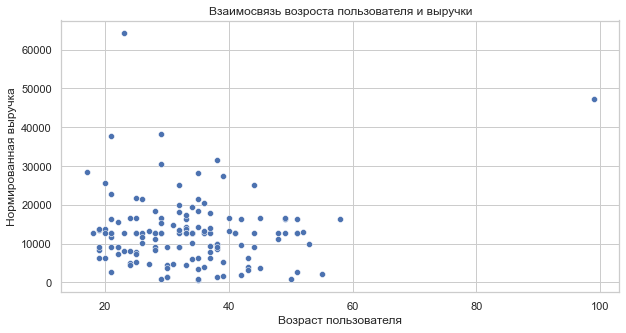

In [43]:
 sns.set(style='whitegrid', rc={'figure.figsize': (10,5)})
sns.scatterplot(x = 'age', y = 'revenue', data = age_category_test)
plt.title('Взаимосвязь возроста пользователя и выручки')
plt.xlabel('Возраст пользователя')
plt.ylabel('Нормированная выручка')

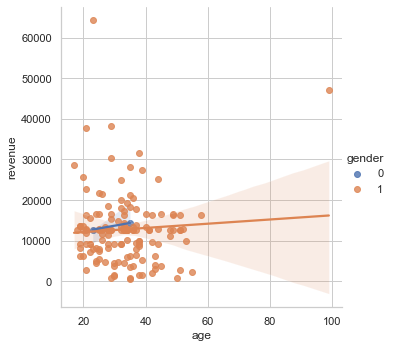

In [44]:
sns.set(style='whitegrid', rc={'figure.figsize': (10,5)})
sns.lmplot(x='age', y='revenue', hue='gender', data=age_category_test)  # с добавлением группирующей переменной 'gender'

In [45]:
# Аналогично выполним для контр. выборки 1:
age_category_1 = transactions_control_1.merge(users_control_1_age, on = 'uid') \
                    .groupby('uid', as_index = False) \
                    .agg({'revenue':'sum', 'payment_id':'count', 'age':'min', 'gender':'min', 'age_category':'min'}) \
                    .rename(columns={'payment_id':'transactions'})


age_category_1['AOV'] = (age_category_1['revenue']/age_category_1['transactions']).round(0)

Text(0, 0.5, 'Нормированная выручка')

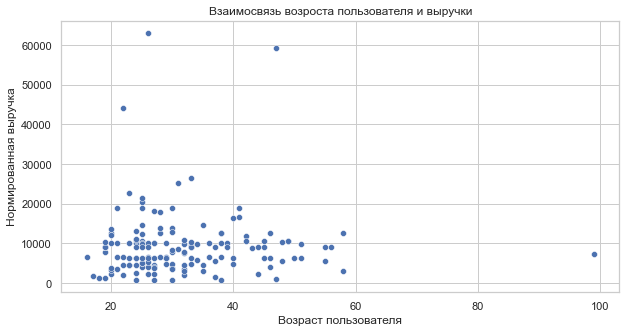

In [46]:
 sns.set(style='whitegrid', rc={'figure.figsize': (10,5)})
sns.scatterplot(x = 'age', y = 'revenue', data = age_category_1)
plt.title('Взаимосвязь возроста пользователя и выручки')
plt.xlabel('Возраст пользователя')
plt.ylabel('Нормированная выручка')

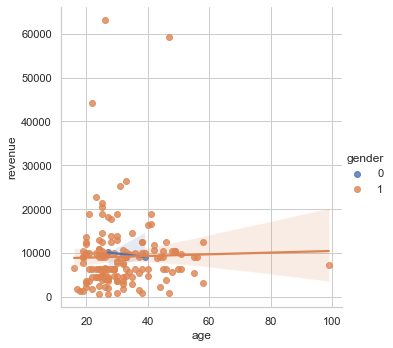

In [47]:
sns.set(style='whitegrid', rc={'figure.figsize': (10,5)})
sns.lmplot(x='age', y='revenue', hue='gender', data=age_category_1)

In [48]:
# Аналогично выполним для контр. выборки 2:
age_category_2 = transactions_control_2.merge(users_control_2_age, on = 'uid') \
                    .groupby('uid', as_index = False) \
                    .agg({'revenue':'sum', 'payment_id':'count', 'age':'min', 'gender':'min', 'age_category':'min'}) \
                    .rename(columns={'payment_id':'transactions'})

age_category_2['AOV'] = (age_category_2['revenue']/age_category_2['transactions']).round(0)

Text(0, 0.5, 'Нормированная выручка')

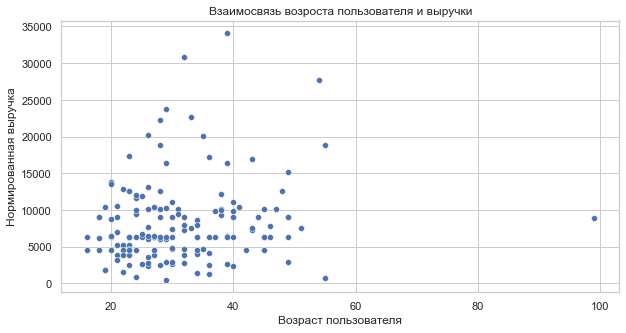

In [49]:
 sns.set(style='whitegrid', rc={'figure.figsize': (10,5)})
sns.scatterplot(x = 'age', y = 'revenue', data = age_category_2)
plt.title('Взаимосвязь возроста пользователя и выручки')
plt.xlabel('Возраст пользователя')
plt.ylabel('Нормированная выручка')

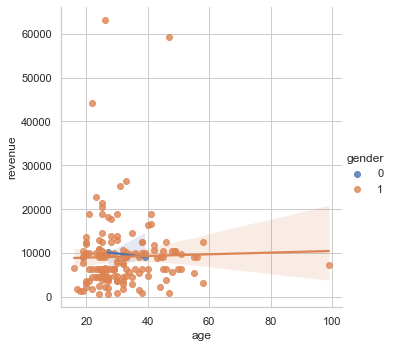

In [50]:
sns.set(style='whitegrid', rc={'figure.figsize': (10,5)})
sns.lmplot(x='age', y='revenue', hue='gender', data=age_category_1)

In [51]:
print(users_control_1.gender.value_counts())
print()
print(users_control_1.gender.value_counts())
print()
print(users_test.gender.value_counts())


1    4158
0     182
Name: gender, dtype: int64

1    4158
0     182
Name: gender, dtype: int64

1    4106
0     202
Name: gender, dtype: int64


**Инсайнт**: Есть подозрение, что система сплитования не совсем верно работала на параметр пола немного съела транзакции женщин). Поэтому можно проверить, правильно ли работает система сплитования по полу, не дескриминирует ли она женщин).  Поэтому, Фактор gender пока не очень интересен для дальнейшего анализа. Поправим данные - проверим еще раз

Ну а вообще, женщины и правда используют сервисы знакомств реже мужчин (вот исследование Касперского www.kaspersky.com/blog/online-dating-report), но сомневаюсь, что в 20 раз

<AxesSubplot:title={'center':'Динамика среднего чека в разрезе возрастных групп'}, xlabel='age_category', ylabel='AOV'>

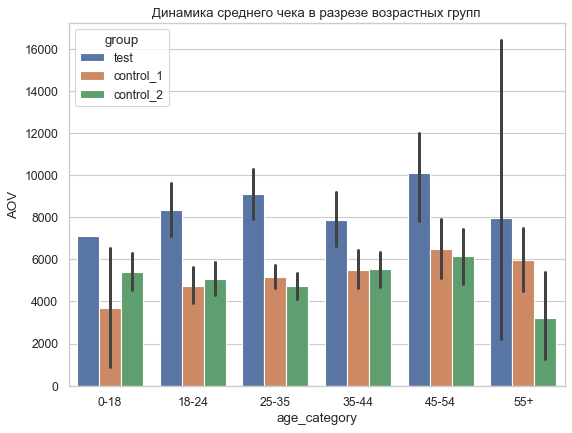

In [52]:
#Столбец 'group', показывающий к какой группе принадлежит выборка
age_category_test['group'] = 'test'
age_category_1['group'] = 'control_1'
age_category_2['group'] = 'control_2'

# Склеим датафреймы в один
age_categories = pd.concat([age_category_test, age_category_1,age_category_2])
#Построим барплот
plt.figure(figsize=(8, 6), dpi=80)
plt.title('Динамика среднего чека в разрезе возрастных групп')
sns.barplot(x="age_category", y="AOV", hue="group", data=age_categories)

**Инсайнт**: Средний чек вырос во всех возрастных группах, значит, новвоведение стоит применять для всех возрастных категорий пользователей. Наиболее активно стали пользоваться платными услугами пользователи среднего возраста.

# Посмотрим на данные в разрезе транзакций по типу продукта:

In [53]:
# Для тестовой выборки:
# Прогруппируем транзакции по типу приобретаемого продукта, найдем  суммарную выручку, средний чек в каждой группе:
test_product_type = transactions_test.groupby('product_type', as_index=False)\
                        .agg({'revenue':'sum','uid':'count'}) \
                        .rename(columns={'uid':'transactions'})
test_product_type['group'] = 'test'
# Находим средний чек
test_product_type['AOV'] = (test_product_type['revenue']/test_product_type['transactions']).round(0)
# Считаем полную выручку
test_product_type['total_revenue'] = test_product_type['revenue'].sum()
# Считаем процент выручки от общей выручки
test_product_type['%_revenue'] = (100*test_product_type['revenue']/test_product_type['total_revenue']).round(0) 


In [54]:
# Аналогично для 1-ой контрольной группы:
c1_product_type = transactions_control_1.groupby('product_type', as_index=False) \
                                    .agg({'revenue':'sum','uid':'count'}) \
                                    .rename(columns={'uid':'transactions'})
c1_product_type['group'] = 'control_1'
c1_product_type['AOV'] = (c1_product_type['revenue']/c1_product_type['transactions']).round(0)
c1_product_type['total_revenue'] = c1_product_type['revenue'].sum()
c1_product_type['%_revenue'] = (100*c1_product_type['revenue']/c1_product_type['total_revenue']).round(0)


In [55]:
# И для 2-ой контрольной группы:
c2_product_type = transactions_control_2.groupby('product_type', as_index=False) \
                                    .agg({'revenue':'sum','uid':'count'}) \
                                    .rename(columns={'uid':'transactions'})
c2_product_type['group'] = 'control_2'
c2_product_type['AOV'] = (c2_product_type['revenue']/c2_product_type['transactions']).round(0)
c2_product_type['total_revenue'] = c2_product_type['revenue'].sum()
c2_product_type['%_revenue'] = (100*c2_product_type['revenue']/c2_product_type['total_revenue']).round(0)


# Объеденим в один датафрейм:
all_product_type = pd.concat([test_product_type, c1_product_type, c2_product_type])

In [56]:
all_product_type

,product_type,revenue,transactions,group,AOV,total_revenue,%_revenue
0,coins,377026.0,100,test,3770.0,1854450.0,20.0
1,other_type,93470.0,27,test,3462.0,1854450.0,5.0
2,premium_no_trial,583752.0,74,test,7889.0,1854450.0,31.0
3,trial_premium,800202.0,62,test,12906.0,1854450.0,43.0
0,coins,442312.0,132,control_1,3351.0,1457040.0,30.0
1,other_type,158158.0,54,control_1,2929.0,1457040.0,11.0
2,premium_no_trial,542425.0,102,control_1,5318.0,1457040.0,37.0
3,trial_premium,314145.0,33,control_1,9520.0,1457040.0,22.0
0,coins,344136.0,120,control_2,2868.0,1284517.0,27.0
1,other_type,128739.0,44,control_2,2926.0,1284517.0,10.0


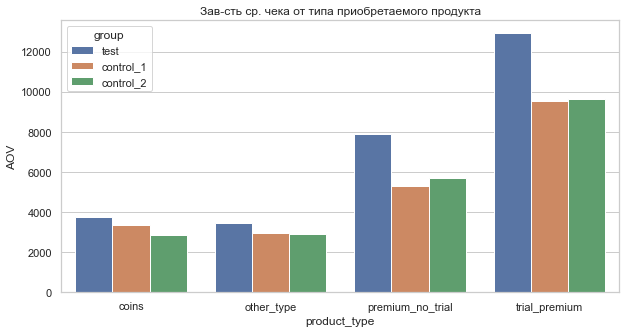

In [57]:
#барплот
plt.title("Зав-cть ср. чека от типа приобретаемого продукта")
sns.barplot(x="product_type", y="AOV", hue="group", data=all_product_type)
plt.show()

Серьезно вырос средний чек в тестовой выборке среди групп пользователей, приобретающих пробную и полную премиум подписку. Средний чек у premium_no_trial из тестовой группы выше на 35% и 39%, чем у людей из 1-ой и 2-ой контрольных групп. А средний чек у trial_premium из тестовой группы выше на 30% и 34%, чем у людей из 1-ой и 2-ой контрольных групп. 

При этом средний чек пользователей, делающих другие покупки, даже незначительно подрос, а затраты на внутреннею валюту сократились. Это может значить, что пользователи пользуются премиум-подписками, не сокращая расходы на другие покупки, но реже покупают внутреннею валюту(coins)

# Коэффициент привлекательности
Коэффициент привлекательности это основа экономики дейтинговых приложений, характеризующая в том числе и поведение пользователя. Возраст же влияет как на платежеспособность, так и на внешность, умение заводить отношения и поддерживать общение, обращение с гаджетами и поведение в социальных сетях.

In [58]:
 mean_1 = round(users_control_1.attraction_coeff.mean())
 mean_test = round(users_test.attraction_coeff.mean())
 mean_2 = round(users_control_2.attraction_coeff.mean())
 mean_test

316

  0%|          | 0/10000 [00:00<?, ?it/s]

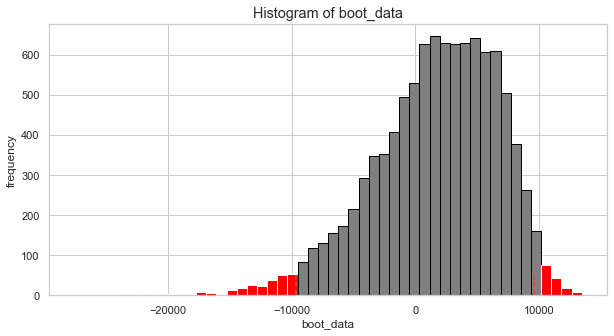

p-value: 0.7391626594996454


In [59]:
attraction_1 = users_control_1.query('attraction_coeff < @mean_1 & total_revenue != 0')['total_revenue']
attraction_test = users_test.query('attraction_coeff < @mean_test & total_revenue != 0')['total_revenue']
booted_data = get_bootstrap(attraction_test, attraction_1)
print('p-value:', booted_data["p_value"])

In [60]:
booted_data["quants"]

,0
0.025,-9618.795952
0.975,9625.599286


Изменение суммы платежей повлияло на пользователей с рейтингом меньше среднего. При этом, это большая группа, которая составляет около половины пользователей. Людям с низким рейтингом нужно чаще использовать платные функции приложений, чтобы привлекать внимание к профилю.

# Заключение


1. А\A-тест показал, что 2 контрольные группы статистически идентичны на 95% уровне значимости, следовательно, система сплитования сработала корректно, а эксперимент прошел успешно.
 

2. Средний чек в тестовой группе на 95% уровне значимости отличатся от среднего чека контрольных групп. Причем наиболее вероятное отклонение значения среднего чека составляет 2500-2600. Таким образом, новвоведение позволило увеличить средний чек на 2400-2600(на 50-60%, между прочим!)


3. По странам средний чек увеличился во Франции, Израиле, Италии, Испании и США. Чтобы посмотреть более корректное изменение среднего чека в разрезе стран, надо бы увеличить объем выборки, поскольку, к сожалению, данных при данном эксперименте было недостаточно.


4. После нововведения значительно повысился средний чек во всех возрастных группах, но наиболее активно стали пользоваться платными услугами пользователи в возрасте 25-35 лет и пользователи в возрасте 45-54(что немного удивило). Еще, есть подозрения, что система сплитования по гендерному признаку работала не совсем корректно. Да и вообще к логгированию есть вопросы, помимо гендера, замечены дубли транзакций, что формирует выбросы в статистиках, а также revenue и total_revenue по описанию обозначают одно и то же, при этом данные в них иногда не одинаковые


5. При появлении новвоведения пользователи чаще пользуются премиум-подписками, не сокращая расходы на другие покупки, но реже покупают внутреннею валюту(coins). При это средний чек группы пользователей, покупающих платную подписку без пробной увеличился на 30-40%, средний чек покупающих пробную подписку вырос на 30%


7. Изменение суммы платежей повлияло на пользователей с коэффициентом привлекательности ниже среднего. Видимо, людям с низким рейтингом нужно чаще использовать платные функции приложений, чтобы привлекать внимание к профилю.
